In [25]:
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df=joblib.load('encoded.pkl')
df.head()


,Vehicle Model,Battery Capacity (kWh),Charging Station Location,Energy Consumed (kWh),Charging Rate (kW),Charging Time Difference (minutes),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type,Energy per 100 km (kWh/100 km),Charging Cost (USD),Long Session
0,0,108.463007,0,60.712346,25.889181,39,0,0,29.371576,85.346739,293.602111,27.947953,2.0,0,0,20.678443,24.284938,0
1,1,100.000000,1,12.339275,30.677735,121,1,1,10.115778,22.455053,112.112804,14.311026,3.0,1,1,11.006125,1.604106,0
2,2,75.000000,1,19.128876,27.513593,168,1,2,6.854604,32.359772,71.799253,21.002002,2.0,2,0,26.642165,4.782219,1
3,1,50.000000,0,79.457824,22.382870,222,0,3,83.120003,100.000000,199.577785,38.316313,1.0,1,2,39.812960,10.329517,0
4,1,50.000000,2,19.629104,10.215712,106,1,3,54.258950,93.517158,203.661847,-7.834199,1.0,1,2,9.638086,2.551784,1


In [10]:
features = [
    "Energy Consumed (kWh)",
    "Charging Rate (kW)",
    "Charging Time Difference (minutes)",
    "Battery Capacity (kWh)",
    "Temperature (°C)",
    "State of Charge (Start %)",
    "State of Charge (End %)",
    "Charging Station Location"
]

X = df[features].copy()

In [11]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Data prepared successfully.")

Data prepared successfully.


In [27]:
iso = IsolationForest(
    n_estimators=300,
    contamination=0.03,       # Force ~3% anomalies
    random_state=42
)

iso.fit(X_scaled)

# Built-in labels: 1 = normal, -1 = anomaly
iso_labels = iso.predict(X_scaled)
iso_labels = (iso_labels == -1).astype(int)

# anomaly score (higher = more anomalous)
iso_scores = -iso.score_samples(X_scaled)

df["Iso_Score"] = iso_scores
df["Iso_Anomaly"] = iso_labels

print("\nIsolation Forest anomalies:", iso_labels.sum())


Isolation Forest anomalies: 280


In [28]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.03,
    novelty=True     # Allow prediction
)

lof.fit(X_scaled)

lof_labels = lof.predict(X_scaled)
lof_labels = (lof_labels == -1).astype(int)

lof_scores = -lof.score_samples(X_scaled)

df["LOF_Score"] = lof_scores
df["LOF_Anomaly"] = lof_labels

print("LOF anomalies:", lof_labels.sum())

LOF anomalies: 239


In [29]:
svm = OneClassSVM(kernel="rbf", gamma=0.1, nu=0.03)
svm.fit(X_scaled)

svm_labels = svm.predict(X_scaled)
svm_labels = (svm_labels == -1).astype(int)

svm_scores = -svm.score_samples(X_scaled)

df["SVM_Score"] = svm_scores
df["SVM_Anomaly"] = svm_labels

print("SVM anomalies:", svm_labels.sum())

SVM anomalies: 279


In [33]:
df.to_pickle("data/anomaly_results.pkl")

print("\n=== ANOMALY DETECTION COMPLETE ===")
print(df[["Iso_Anomaly", "LOF_Anomaly", "SVM_Anomaly"]])


=== ANOMALY DETECTION COMPLETE ===
      Iso_Anomaly  LOF_Anomaly  SVM_Anomaly
0               0            0            0
1               0            0            0
2               0            0            0
3               0            0            1
4               0            0            0
...           ...          ...          ...
9315            0            0            0
9316            0            0            0
9317            0            0            0
9318            0            0            0
9319            0            0            0

[9320 rows x 3 columns]


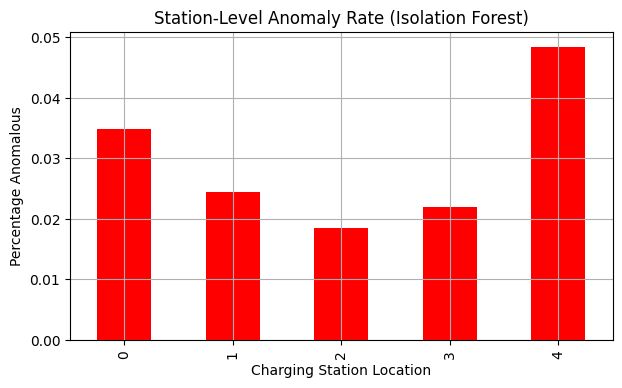

In [36]:
station_anoms = df.groupby("Charging Station Location")["Iso_Anomaly"].mean()

plt.figure(figsize=(7,4))
station_anoms.plot(kind="bar", color="red")
plt.title("Station-Level Anomaly Rate (Isolation Forest)")
plt.ylabel("Percentage Anomalous")
plt.grid()
plt.show()

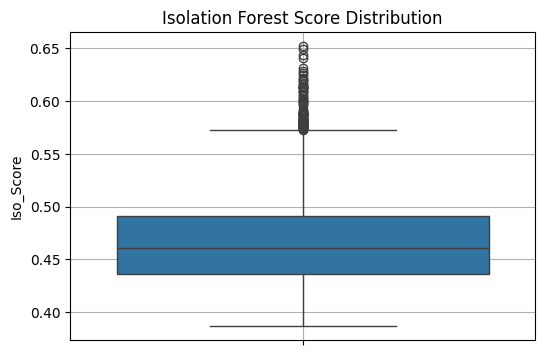

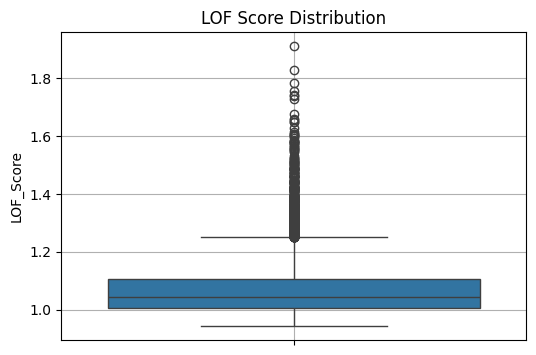

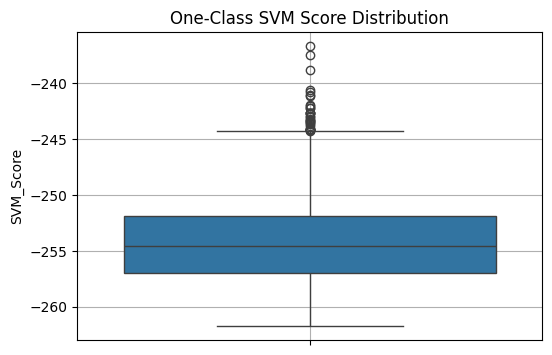

In [37]:
plt.figure(figsize=(6,4))
sns.boxplot(df["Iso_Score"])
plt.title("Isolation Forest Score Distribution")
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(df["LOF_Score"])
plt.title("LOF Score Distribution")
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(df["SVM_Score"])
plt.title("One-Class SVM Score Distribution")
plt.grid()
plt.show()


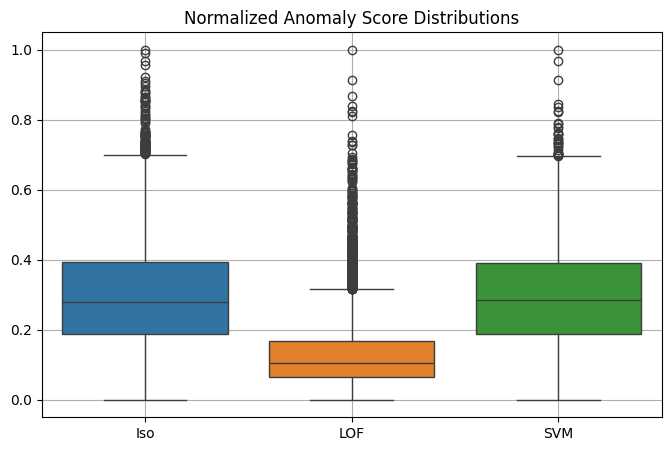

In [39]:
import pandas as pd
plot_scores = pd.DataFrame()
plot_scores["Iso"] = (df["Iso_Score"] - df["Iso_Score"].min()) / (df["Iso_Score"].max() - df["Iso_Score"].min())
plot_scores["LOF"] = (df["LOF_Score"] - df["LOF_Score"].min()) / (df["LOF_Score"].max() - df["LOF_Score"].min())
plot_scores["SVM"] = (df["SVM_Score"] - df["SVM_Score"].min()) / (df["SVM_Score"].max() - df["SVM_Score"].min())

plt.figure(figsize=(8,5))
sns.boxplot(data=plot_scores)
plt.title("Normalized Anomaly Score Distributions")
plt.grid()
plt.show()


In [41]:

joblib.dump(iso, 'saved_models/iso_model.pkl')
joblib.dump(lof, 'saved_models/lof_model.pkl')
joblib.dump(svm, 'saved_models/svm_model.pkl')

joblib.dump(scaler, 'saved_models/anomaly_scaler.pkl')
print('Saved iso, lof, svm and scaler to saved_models/')

Saved iso, lof, svm and scaler to saved_models/
